In [1]:
# =========================
# CELL 0: Universal installs (Project 3)
# Run ONCE at top of a fresh runtime
# =========================

# Colab-safe numeric + viz
# !pip -q install \
#   numpy==2.0.2 \
#   pandas==2.2.2 \
#   pillow==11.3.0 \
#   matplotlib==3.8.4 \
#   tqdm==4.66.4 \
#   scikit-learn==1.5.1


# # HF datasets + parquet support
# !pip -q install datasets==2.20.0 pyarrow==16.1.0

# # Transformers (for later text modeling; safe to install now)
# !pip -q install transformers==4.46.3

# Sanity check
import torch, torchvision, numpy, pandas, PIL, datasets, pyarrow, transformers
print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("pillow:", PIL.__version__)
print("datasets:", datasets.__version__)
print("pyarrow:", pyarrow.__version__)
print("transformers:", transformers.__version__)


torch: 2.6.0+cu124 cuda: True
torchvision: 0.21.0+cu124
numpy: 2.3.5
pandas: 2.3.3
pillow: 12.0.0
datasets: 4.4.1
pyarrow: 22.0.0
transformers: 4.57.1


In [2]:
# =========================
# CELL 1: Dataset download + load (StoryReasoning)
# =========================

from pathlib import Path
from datasets import load_dataset

CACHE_DIR = Path(r"E:\_cache\storyreasoning\datasets")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

ds = load_dataset("daniel3303/StoryReasoning", cache_dir=str(CACHE_DIR))

train_raw = ds["train"]
test_raw  = ds["test"]

print(ds)
print("Train rows:", len(train_raw), "Test rows:", len(test_raw))
print("Columns:", train_raw.column_names)
print("Features:", train_raw.features)


DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})
Train rows: 3552 Test rows: 626
Columns: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story']
Features: {'story_id': Value('string'), 'images': List(Image(mode=None, decode=True)), 'frame_count': Value('int32'), 'chain_of_thought': Value('string'), 'story': Value('string')}


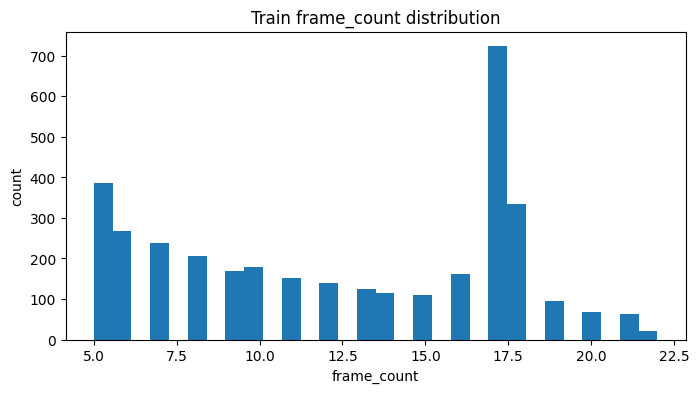

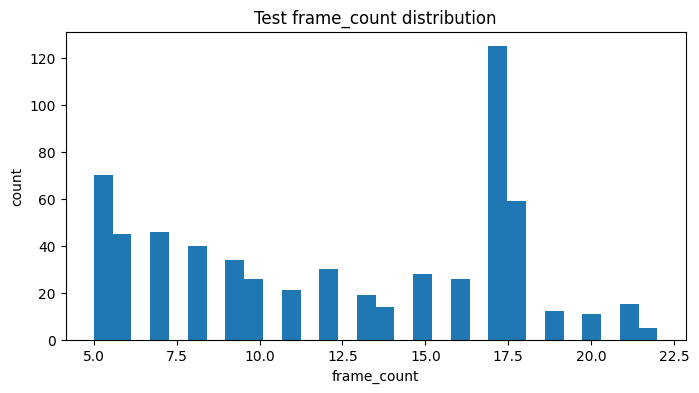

C:\Users\shaido\AppData\Local\Temp\ipykernel_19240\3988750333.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fc_train, fc_test], labels=["train", "test"])


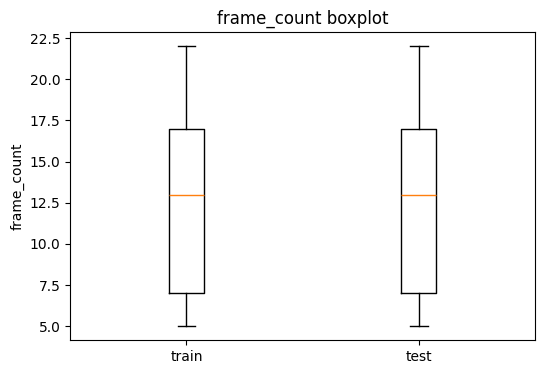

EDA sampling (text/entities):   0%|          | 0/800 [00:00<?, ?it/s]

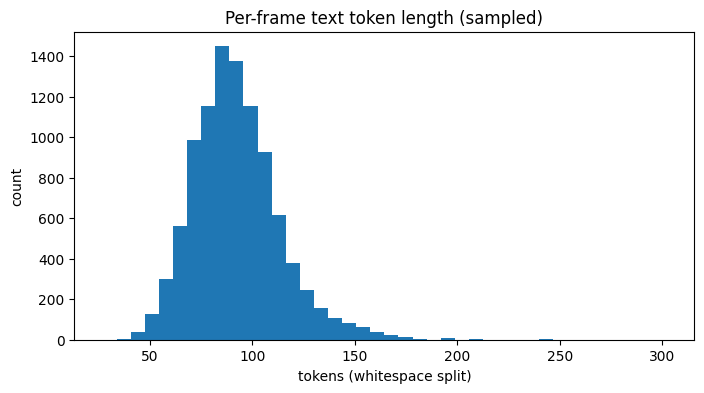

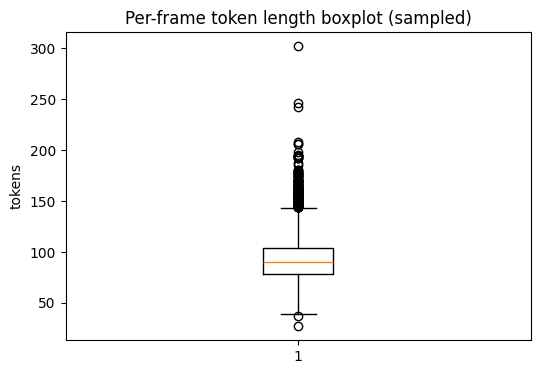

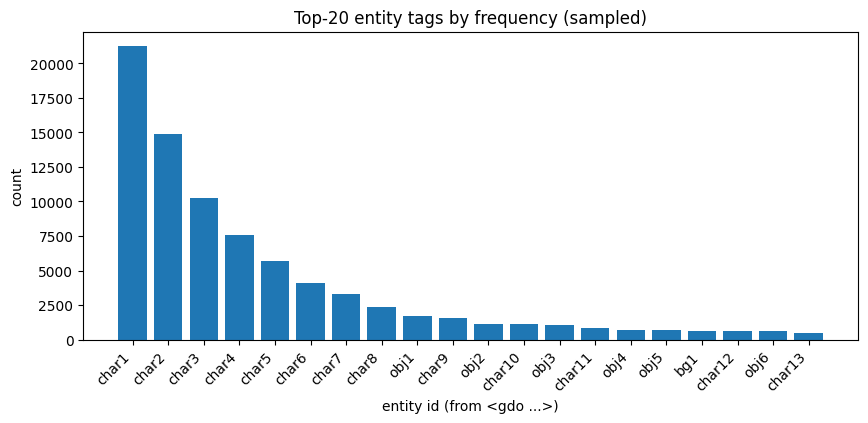

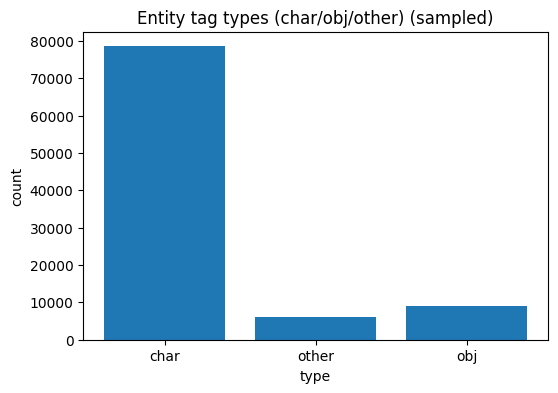

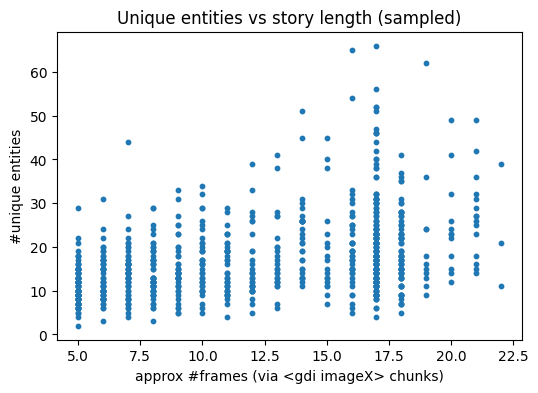

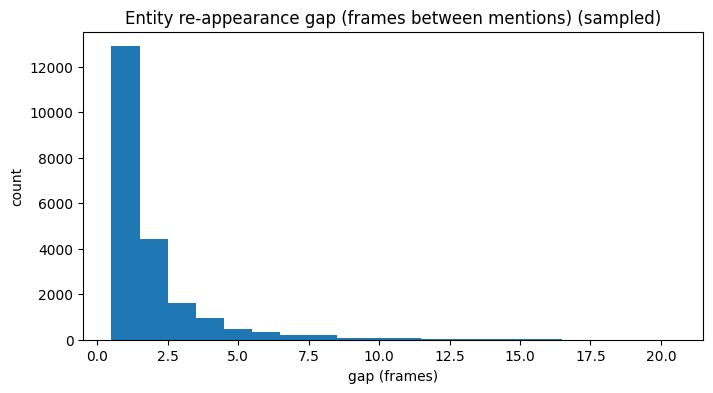

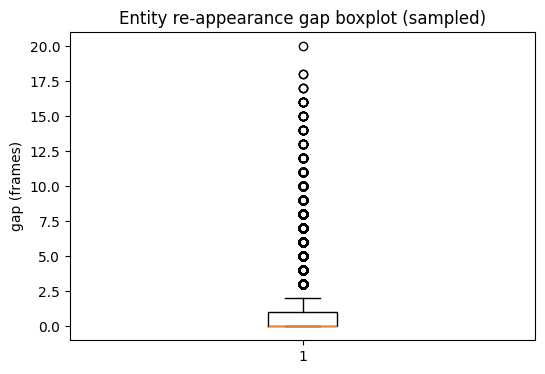

Gap stats (sampled):
  count: 79731
  mean: 0.5231842068956868 median: 0 max: 20

EDA summary (sampled):
  token_lens count: 9812 mean: 92.25835711373828
  unique entity tags: 898
  top entity types: {'char': 78517, 'other': 6004, 'obj': 9089}
  story sample size: 800


In [3]:
# =========================
# CELL 2: EDA for Project 3 (memory motivation)
# - frame_count distribution
# - per-frame text length distribution (approx segmentation)
# - entity tag frequency (char/obj)
# - unique entities per story vs story length
# - re-appearance gap statistics (long-range dependency indicator)
# =========================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter, defaultdict

# ---------- Helpers ----------
re_frame = re.compile(r"<gdi\s+image\d+>\s*(.*?)(?=(?:<gdi\s+image\d+>)|$)", re.DOTALL | re.IGNORECASE)
re_entity_open = re.compile(r"<gdo\s+([^>]+)>", re.IGNORECASE)  # captures "char1" / "obj7" / etc.

def extract_frame_texts(story_text: str):
    """Returns list of per-frame text chunks (best-effort) using <gdi imageX> markers."""
    if story_text is None:
        return []
    chunks = [m.group(1).strip() for m in re_frame.finditer(story_text)]
    return [c for c in chunks if len(c) > 0]

def extract_entity_ids(text: str):
    """Extract entity IDs from <gdo ...> tags."""
    if text is None:
        return []
    return [m.group(1).strip() for m in re_entity_open.finditer(text)]

def simple_token_len(text: str):
    return len(text.split()) if text else 0

# ---------- 2.1 frame_count distributions ----------
fc_train = np.array(train_raw["frame_count"])
fc_test  = np.array(test_raw["frame_count"])

plt.figure(figsize=(8,4))
plt.hist(fc_train, bins=30)
plt.title("Train frame_count distribution")
plt.xlabel("frame_count")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(8,4))
plt.hist(fc_test, bins=30)
plt.title("Test frame_count distribution")
plt.xlabel("frame_count")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot([fc_train, fc_test], labels=["train", "test"])
plt.title("frame_count boxplot")
plt.ylabel("frame_count")
plt.show()

# ---------- 2.2 Sample stories for text/entity EDA (fast) ----------
N_STORIES = 800  # increase for deeper EDA
rng = np.random.default_rng(42)
sample_idxs = rng.choice(np.arange(len(train_raw)), size=min(N_STORIES, len(train_raw)), replace=False)

token_lens = []
entities_all = Counter()
entity_type_counts = Counter()
uniq_entities_per_story = []
story_len_frames = []
gap_values = []

for idx in tqdm(sample_idxs, desc="EDA sampling (text/entities)"):
    ex = train_raw[int(idx)]
    story = ex.get("story", "")
    frames = extract_frame_texts(story)

    # Fallback: if segmentation fails, treat entire story as one chunk
    if len(frames) == 0 and story:
        frames = [story]

    story_len_frames.append(len(frames))

    # Token lengths per frame
    for ft in frames:
        token_lens.append(simple_token_len(ft))

    # Entities per frame + gaps
    ent_positions = defaultdict(list)
    for t, ft in enumerate(frames):
        ent_ids = extract_entity_ids(ft)
        for eid in ent_ids:
            entities_all[eid] += 1
            low = eid.lower()
            if low.startswith("char"):
                entity_type_counts["char"] += 1
            elif low.startswith("obj"):
                entity_type_counts["obj"] += 1
            else:
                entity_type_counts["other"] += 1
            ent_positions[eid].append(t)

    uniq_entities_per_story.append(len(ent_positions))

    for eid, pos in ent_positions.items():
        if len(pos) >= 2:
            pos = sorted(pos)
            gaps = [pos[i] - pos[i-1] for i in range(1, len(pos))]
            gap_values.extend(gaps)

# ---------- 2.3 Token length distribution ----------
token_lens = np.array(token_lens, dtype=np.int32)

plt.figure(figsize=(8,4))
plt.hist(token_lens, bins=40)
plt.title("Per-frame text token length (sampled)")
plt.xlabel("tokens (whitespace split)")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(token_lens, vert=True)
plt.title("Per-frame token length boxplot (sampled)")
plt.ylabel("tokens")
plt.show()

# ---------- 2.4 Entity frequency ----------
top_entities = entities_all.most_common(20)
labels = [k for k, _ in top_entities]
vals = [v for _, v in top_entities]

plt.figure(figsize=(10,4))
plt.bar(labels, vals)
plt.title("Top-20 entity tags by frequency (sampled)")
plt.xlabel("entity id (from <gdo ...>)")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(list(entity_type_counts.keys()), list(entity_type_counts.values()))
plt.title("Entity tag types (char/obj/other) (sampled)")
plt.xlabel("type")
plt.ylabel("count")
plt.show()

# ---------- 2.5 Unique entities per story vs story length ----------
df_story = pd.DataFrame({
    "story_frames": story_len_frames,
    "unique_entities": uniq_entities_per_story
})

plt.figure(figsize=(6,4))
plt.scatter(df_story["story_frames"], df_story["unique_entities"], s=10)
plt.title("Unique entities vs story length (sampled)")
plt.xlabel("approx #frames (via <gdi imageX> chunks)")
plt.ylabel("#unique entities")
plt.show()

# ---------- 2.6 Re-appearance gap stats ----------
if len(gap_values) > 0:
    gaps = np.array(gap_values, dtype=np.int32)
    plt.figure(figsize=(8,4))
    plt.hist(gaps, bins=np.arange(1, min(gaps.max(), 25) + 2) - 0.5)
    plt.title("Entity re-appearance gap (frames between mentions) (sampled)")
    plt.xlabel("gap (frames)")
    plt.ylabel("count")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.boxplot(gaps, vert=True)
    plt.title("Entity re-appearance gap boxplot (sampled)")
    plt.ylabel("gap (frames)")
    plt.show()

    print("Gap stats (sampled):")
    print("  count:", len(gaps))
    print("  mean:", float(gaps.mean()), "median:", int(np.median(gaps)), "max:", int(gaps.max()))
else:
    print("No entity gaps detected in sampled stories (check marker parsing).")

print("\nEDA summary (sampled):")
print("  token_lens count:", len(token_lens), "mean:", float(token_lens.mean()) if len(token_lens) else None)
print("  unique entity tags:", len(entities_all))
print("  top entity types:", dict(entity_type_counts))
print("  story sample size:", len(sample_idxs))


Recomputing entity gaps (dedup/frame):   0%|          | 0/800 [00:00<?, ?it/s]

Dedup gap stats (sampled):
  total gaps: 21487
  gap==0 count: 0 (0.00%)
  all gaps mean: 1.9413598920277377 median: 1 max: 20
  positive gaps mean: 1.9413598920277377 median: 1 max: 20


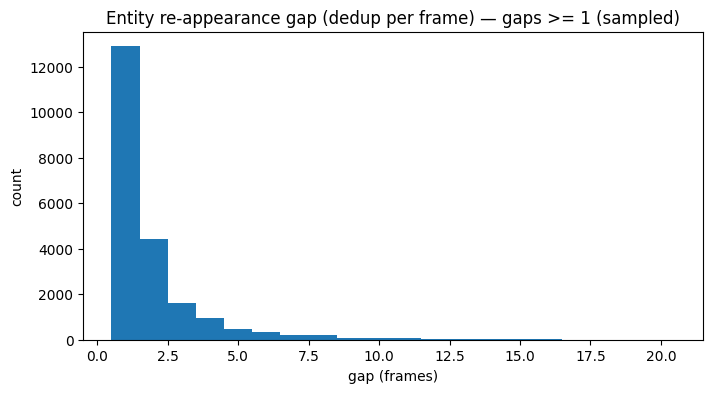

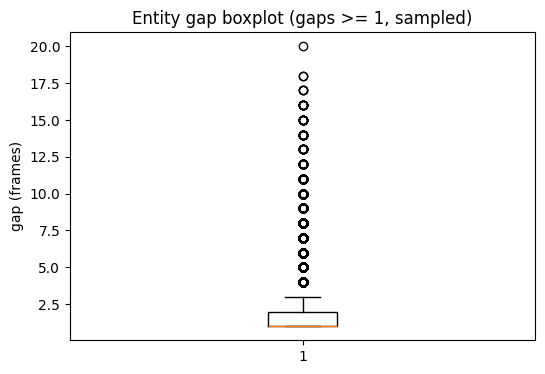

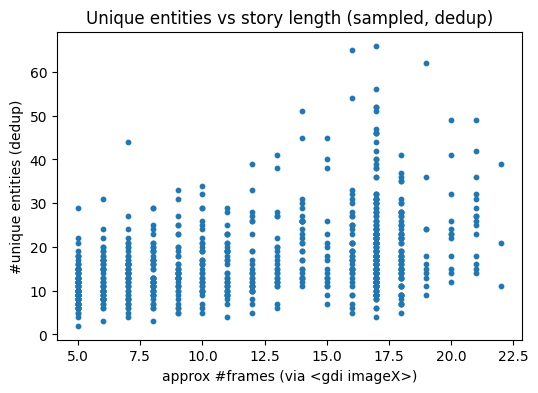

Done.


In [4]:
# =========================
# CELL 3: Proper gap stats (fixes the "median=0" issue) + Memory motivation plots
# Why your gap median was 0:
# - You counted multiple <gdo ...> occurrences inside the SAME frame, so repeated mentions at t produce gap=0.
# Fix:
# - Deduplicate entity ids per frame before recording positions.
# Outputs:
# - gap histogram (gaps >= 1 only)
# - ratio of same-frame repeats (gap=0 share)
# - story length vs unique entities scatter (full sample)
# =========================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import defaultdict

re_frame = re.compile(r"<gdi\s+image\d+>\s*(.*?)(?=(?:<gdi\s+image\d+>)|$)", re.DOTALL | re.IGNORECASE)
re_entity_open = re.compile(r"<gdo\s+([^>]+)>", re.IGNORECASE)

def extract_frame_texts(story_text: str):
    if story_text is None:
        return []
    chunks = [m.group(1).strip() for m in re_frame.finditer(story_text)]
    return [c for c in chunks if len(c) > 0]

def extract_entity_ids(text: str):
    if text is None:
        return []
    return [m.group(1).strip() for m in re_entity_open.finditer(text)]

# sample same stories as before or resample
N_STORIES = 800
rng = np.random.default_rng(42)
sample_idxs = rng.choice(np.arange(len(train_raw)), size=min(N_STORIES, len(train_raw)), replace=False)

gap_values_all = []
gap_values_pos = []
zero_gap_count = 0
total_gaps = 0

story_len_frames = []
uniq_entities_per_story = []

for idx in tqdm(sample_idxs, desc="Recomputing entity gaps (dedup/frame)"):
    ex = train_raw[int(idx)]
    story = ex.get("story", "")
    frames = extract_frame_texts(story)
    if len(frames) == 0 and story:
        frames = [story]

    story_len_frames.append(len(frames))

    ent_positions = defaultdict(list)
    for t, ft in enumerate(frames):
        # KEY FIX: deduplicate entities per frame
        ent_ids = set(extract_entity_ids(ft))
        for eid in ent_ids:
            ent_positions[eid].append(t)

    uniq_entities_per_story.append(len(ent_positions))

    for eid, pos in ent_positions.items():
        if len(pos) >= 2:
            pos = sorted(pos)
            for i in range(1, len(pos)):
                g = pos[i] - pos[i-1]
                gap_values_all.append(g)
                total_gaps += 1
                if g == 0:
                    zero_gap_count += 1
                else:
                    gap_values_pos.append(g)

gap_values_all = np.array(gap_values_all, dtype=np.int32) if len(gap_values_all) else np.array([], dtype=np.int32)
gap_values_pos = np.array(gap_values_pos, dtype=np.int32) if len(gap_values_pos) else np.array([], dtype=np.int32)

print("Dedup gap stats (sampled):")
if len(gap_values_all):
    print("  total gaps:", int(total_gaps))
    print("  gap==0 count:", int(zero_gap_count), f"({(zero_gap_count/max(total_gaps,1))*100:.2f}%)")
    print("  all gaps mean:", float(gap_values_all.mean()), "median:", int(np.median(gap_values_all)), "max:", int(gap_values_all.max()))
else:
    print("  no gaps found")

if len(gap_values_pos):
    print("  positive gaps mean:", float(gap_values_pos.mean()), "median:", int(np.median(gap_values_pos)), "max:", int(gap_values_pos.max()))
else:
    print("  no positive gaps found (check parsing)")

# Plot positive gaps only (true long-range re-appearance)
if len(gap_values_pos):
    plt.figure(figsize=(8,4))
    bins = np.arange(1, min(int(gap_values_pos.max()), 30) + 2) - 0.5
    plt.hist(gap_values_pos, bins=bins)
    plt.title("Entity re-appearance gap (dedup per frame) — gaps >= 1 (sampled)")
    plt.xlabel("gap (frames)")
    plt.ylabel("count")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.boxplot(gap_values_pos, vert=True)
    plt.title("Entity gap boxplot (gaps >= 1, sampled)")
    plt.ylabel("gap (frames)")
    plt.show()

# Story length vs unique entities (memory motivation)
df_story = pd.DataFrame({"story_frames": story_len_frames, "unique_entities": uniq_entities_per_story})

plt.figure(figsize=(6,4))
plt.scatter(df_story["story_frames"], df_story["unique_entities"], s=10)
plt.title("Unique entities vs story length (sampled, dedup)")
plt.xlabel("approx #frames (via <gdi imageX>)")
plt.ylabel("#unique entities (dedup)")
plt.show()

print("Done.")


In [4]:
# =========================
# CELL 4: Story-level split (train/val) + build sliding-window indices for Project 3 (text prediction)
# Produces:
# - train_ids, val_ids (story_id split, no leakage)
# - train_index / val_index / test_index:
#     list of tuples: (row_idx, t, frame_count)
#   where t is the target frame index, and context is [t-K ... t-1]
# =========================

import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

K = 6          # Project 3: use longer context to justify memory; try 4/6/8 later
VAL_FRAC = 0.10
SEED = 42

# story-level split on train_raw
all_story_ids = np.array(train_raw["story_id"])
unique_ids = np.unique(all_story_ids)

train_ids, val_ids = train_test_split(unique_ids, test_size=VAL_FRAC, random_state=SEED, shuffle=True)

# map story_id -> row index (train_raw has unique story_id per row in this dataset)
storyid_to_idx_trainraw = {sid: i for i, sid in enumerate(train_raw["story_id"])}

train_story_indices = [storyid_to_idx_trainraw[sid] for sid in train_ids]
val_story_indices   = [storyid_to_idx_trainraw[sid] for sid in val_ids]

print("Train stories:", len(train_story_indices), "Val stories:", len(val_story_indices), "Test stories:", len(test_raw))

def build_index_table(split, story_row_indices, K=6, require_markers=False):
    """
    Build index rows: (row_idx, t, frame_count)
    - context frames are [t-K .. t-1]
    - target frame is t
    If require_markers=True, we only keep stories where <gdi imageX> markers exist.
    """
    idx_rows = []
    kept = 0
    for row_idx in tqdm(story_row_indices, desc="Indexing stories"):
        ex = split[int(row_idx)]
        fc = int(ex["frame_count"])
        story = ex.get("story", "")

        if require_markers:
            # quick marker check (fast)
            if story is None or "<gdi image" not in story.lower():
                continue

        if fc < K + 1:
            continue

        for t in range(K, fc):
            idx_rows.append((int(row_idx), int(t), int(fc)))
        kept += 1

    return idx_rows, kept

# Index train/val from train_raw; test uses all rows in test_raw
train_index, kept_train = build_index_table(train_raw, train_story_indices, K=K, require_markers=False)
val_index,   kept_val   = build_index_table(train_raw, val_story_indices,   K=K, require_markers=False)
test_index,  kept_test  = build_index_table(test_raw, list(range(len(test_raw))), K=K, require_markers=False)

print("\nIndex summary:")
print("  kept train stories:", kept_train, "-> samples:", len(train_index))
print("  kept val stories:", kept_val, "-> samples:", len(val_index))
print("  kept test stories:", kept_test, "-> samples:", len(test_index))

# Quick sanity: show one index row
print("Example index row:", train_index[0])


Train stories: 3196 Val stories: 356 Test stories: 626


Indexing stories:   0%|          | 0/3196 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/356 [00:00<?, ?it/s]

Indexing stories:   0%|          | 0/626 [00:00<?, ?it/s]


Index summary:
  kept train stories: 2621 -> samples: 21053
  kept val stories: 279 -> samples: 2219
  kept test stories: 511 -> samples: 4072
Example index row: (1863, 6, 15)


In [5]:
# =========================
# CELL 5: Frame-text extraction + Dataset object for Project 3
# Each sample returns:
# - ctx_images: [K] PIL images (leave as PIL for now; later encode via frozen CNN)
# - ctx_texts:  list[str] length K
# - target_text: str (next frame)
# - ctx_entity_sets: list[set[str]] length K  (for contradiction/hallucination metrics)
# - target_entity_set: set[str]
# =========================

import re
from torch.utils.data import Dataset

re_frame = re.compile(r"<gdi\s+image\d+>\s*(.*?)(?=(?:<gdi\s+image\d+>)|$)", re.DOTALL | re.IGNORECASE)
re_entity_open = re.compile(r"<gdo\s+([^>]+)>", re.IGNORECASE)

def extract_frame_texts(story_text: str):
    if story_text is None:
        return []
    chunks = [m.group(1).strip() for m in re_frame.finditer(story_text)]
    return [c for c in chunks if len(c) > 0]

def extract_entity_ids(text: str):
    if text is None:
        return []
    return [m.group(1).strip() for m in re_entity_open.finditer(text)]

class StoryTextNextDataset(Dataset):
    def __init__(self, base_split, index_rows, K=6):
        self.base = base_split
        self.index = index_rows
        self.K = K

    def __len__(self):
        return len(self.index)

    def __getitem__(self, i):
        row_idx, t, fc = self.index[i]
        ex = self.base[int(row_idx)]

        imgs = ex["images"]  # list of PIL Images
        story = ex.get("story", "")
        frame_texts = extract_frame_texts(story)

        # fallback if markers missing
        if len(frame_texts) == 0:
            frame_texts = [story] * int(ex["frame_count"])

        # align lengths defensively
        # some samples can have slight mismatch between parsed chunks and frame_count
        # we clamp indices to available range
        maxT = min(len(imgs), len(frame_texts), int(ex["frame_count"]))
        if maxT <= self.K:
            # should not happen due to indexing, but safe
            raise IndexError("Not enough frames after alignment.")

        t = min(int(t), maxT - 1)

        ctx_imgs = imgs[t-self.K:t]
        tgt_img  = imgs[t]  # kept for later embedding target/retrieval

        ctx_txts = frame_texts[t-self.K:t]
        tgt_txt  = frame_texts[t]

        ctx_ents = [set(extract_entity_ids(s)) for s in ctx_txts]
        tgt_ents = set(extract_entity_ids(tgt_txt))

        return {
            "story_id": ex["story_id"],
            "row_idx": int(row_idx),
            "t_index": int(t),
            "frame_count": int(ex["frame_count"]),
            "ctx_images": ctx_imgs,
            "target_image": tgt_img,
            "ctx_texts": ctx_txts,
            "target_text": tgt_txt,
            "ctx_entity_sets": ctx_ents,
            "target_entity_set": tgt_ents,
        }

train_ds_p3 = StoryTextNextDataset(train_raw, train_index, K=K)
val_ds_p3   = StoryTextNextDataset(train_raw, val_index,   K=K)
test_ds_p3  = StoryTextNextDataset(test_raw,  test_index,  K=K)

print("Datasets:", len(train_ds_p3), len(val_ds_p3), len(test_ds_p3))

# Sanity check one sample
s = train_ds_p3[0]
print("Keys:", s.keys())
print("ctx_texts:", len(s["ctx_texts"]), "target_text_len:", len(s["target_text"]))
print("ctx_entities sizes:", [len(x) for x in s["ctx_entity_sets"]], "target_entities:", len(s["target_entity_set"]))


Datasets: 21053 2219 4072
Keys: dict_keys(['story_id', 'row_idx', 't_index', 'frame_count', 'ctx_images', 'target_image', 'ctx_texts', 'target_text', 'ctx_entity_sets', 'target_entity_set'])
ctx_texts: 6 target_text_len: 443
ctx_entities sizes: [4, 4, 3, 1, 3, 1] target_entities: 2


In [7]:
# =========================
# CELL 6: Tokenization + DataLoaders (Project 3)
# - Tokenizes context texts (K) and target text
# - Pads/truncates to max lengths
# - Builds DataLoaders with a collate_fn
# Output batch:
#   ctx_input_ids:   [B,K,Lc]
#   ctx_attn_mask:   [B,K,Lc]
#   tgt_input_ids:   [B,Lt]   (for teacher forcing; includes bos/eos depending on tokenizer)
#   tgt_attn_mask:   [B,Lt]
#   entity sets kept as python lists for later metrics
# =========================

#!pip -q install "transformers==4.46.3"

import torch
from pathlib import Path
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Use a compact tokenizer. DistilBERT tokenizer is fine for encoding text.
TOKENIZER_NAME = "distilbert-base-uncased"
TOKENIZER_CACHE_DIR = Path(r"E:\_cache\storyreasoning\transformers")
TOKENIZER_CACHE_DIR.mkdir(parents=True, exist_ok=True)
tok = AutoTokenizer.from_pretrained(TOKENIZER_NAME, cache_dir=str(TOKENIZER_CACHE_DIR))

# If tokenizer has no pad token (some do), set it safely
if tok.pad_token is None:
    tok.pad_token = tok.eos_token if tok.eos_token is not None else "[PAD]"

K = 6

# Length limits (tune for VRAM)
CTX_MAX_LEN = 128   # per-context-frame text length
TGT_MAX_LEN = 160   # next-frame text length

def collate_p3(batch):
    # batch is list of dicts
    ctx_texts = [b["ctx_texts"] for b in batch]          # list length B; each is list length K
    tgt_texts = [b["target_text"] for b in batch]

    # flatten context texts for tokenization then reshape back
    flat_ctx = [ctx_texts[i][j] for i in range(len(batch)) for j in range(K)]

    ctx_enc = tok(
        flat_ctx,
        padding=True,
        truncation=True,
        max_length=CTX_MAX_LEN,
        return_tensors="pt"
    )
    # reshape to [B,K,L]
    B = len(batch)
    Lc = ctx_enc["input_ids"].shape[1]
    ctx_input_ids = ctx_enc["input_ids"].view(B, K, Lc)
    ctx_attn_mask = ctx_enc["attention_mask"].view(B, K, Lc)

    tgt_enc = tok(
        tgt_texts,
        padding=True,
        truncation=True,
        max_length=TGT_MAX_LEN,
        return_tensors="pt"
    )
    tgt_input_ids = tgt_enc["input_ids"]
    tgt_attn_mask = tgt_enc["attention_mask"]

    # keep images as PIL list for now; we will embed them later with ResNet
    ctx_images = [b["ctx_images"] for b in batch]  # list of lists
    target_images = [b["target_image"] for b in batch]

    return {
        "story_id": [b["story_id"] for b in batch],
        "row_idx": torch.tensor([b["row_idx"] for b in batch], dtype=torch.long),
        "t_index": torch.tensor([b["t_index"] for b in batch], dtype=torch.long),
        "frame_count": torch.tensor([b["frame_count"] for b in batch], dtype=torch.long),

        "ctx_input_ids": ctx_input_ids,
        "ctx_attn_mask": ctx_attn_mask,
        "tgt_input_ids": tgt_input_ids,
        "tgt_attn_mask": tgt_attn_mask,

        "ctx_images": ctx_images,
        "target_images": target_images,

        "ctx_entity_sets": [b["ctx_entity_sets"] for b in batch],
        "target_entity_set": [b["target_entity_set"] for b in batch],
    }

BATCH_SIZE = 8  # safe start; increase if GPU allows
train_loader_p3 = DataLoader(train_ds_p3, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, collate_fn=collate_p3)
val_loader_p3   = DataLoader(val_ds_p3,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_p3)

# Sanity batch
batch = next(iter(train_loader_p3))
print("ctx_input_ids:", batch["ctx_input_ids"].shape)  # [B,K,Lc]
print("tgt_input_ids:", batch["tgt_input_ids"].shape)  # [B,Lt]
print("ctx_images lens:", len(batch["ctx_images"]), len(batch["ctx_images"][0]))
print("example target text tokens:", batch["tgt_input_ids"][0, :20].tolist())


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

ctx_input_ids: torch.Size([8, 6, 128])
tgt_input_ids: torch.Size([8, 160])
ctx_images lens: 8 6
example target text tokens: [101, 1996, 2154, 3092, 2007, 1026, 1043, 3527, 25869, 2509, 1028, 3505, 1026, 1013, 1043, 3527, 1028, 1026, 1043, 2850]


In [8]:
# =========================
# CELL 7: Frozen ResNet18 embeddings for images (ctx + target) + optional caching
# Output added to batch (for later model):
#   ctx_img_emb:   [B,K,512]
#   tgt_img_emb:   [B,512]
#
# Notes:
# - Uses torchvision ResNet18 pretrained weights
# - Keeps model frozen and in eval mode
# - Converts PIL -> tensor, normalize
# - Optional: on-the-fly only (fast enough to start). If you want caching, ask and I'll add it.
# =========================

import os
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models, transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Force torchvision/torch hub downloads to E:
TORCH_CACHE = Path(r"E:\_cache\storyreasoning\torch")
TORCH_CACHE.mkdir(parents=True, exist_ok=True)
os.environ["TORCH_HOME"] = str(TORCH_CACHE)
torch.hub.set_dir(str(TORCH_CACHE))

# -------- ResNet18 feature extractor (512-d) --------
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Identity()
resnet = resnet.to(DEVICE).eval()
for p in resnet.parameters():
    p.requires_grad = False

img_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

@torch.no_grad()
def embed_pil_list(pil_list):
    # pil_list: list[PIL.Image]
    x = torch.stack([img_tf(im.convert("RGB")) for im in pil_list], dim=0).to(DEVICE)  # [N,3,224,224]
    e = resnet(x)  # [N,512]
    return e

@torch.no_grad()
def add_image_embeddings_to_batch(batch):
    # batch["ctx_images"] is list length B; each element is list length K of PIL
    B = len(batch["ctx_images"])
    K = len(batch["ctx_images"][0])

    # flatten all ctx images then reshape
    flat_ctx = []
    for i in range(B):
        flat_ctx.extend(batch["ctx_images"][i])
    ctx_e = embed_pil_list(flat_ctx)                 # [B*K, 512]
    ctx_e = ctx_e.view(B, K, -1)                     # [B,K,512]

    # target images
    tgt_e = embed_pil_list(batch["target_images"])   # [B,512]

    batch["ctx_img_emb"] = ctx_e
    batch["tgt_img_emb"] = tgt_e
    return batch

# -------- Sanity check on one batch --------
batch = next(iter(train_loader_p3))
batch = add_image_embeddings_to_batch(batch)

print("ctx_img_emb:", batch["ctx_img_emb"].shape)  # [B,K,512]
print("tgt_img_emb:", batch["tgt_img_emb"].shape)  # [B,512]
print("dtype/device:", batch["ctx_img_emb"].dtype, batch["ctx_img_emb"].device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to E:\_cache\storyreasoning\torch\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:24<00:00, 1.91MB/s]


ctx_img_emb: torch.Size([8, 6, 512])
tgt_img_emb: torch.Size([8, 512])
dtype/device: torch.float32 cuda:0


In [21]:
import re
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ---------- Entity extraction from decoded text ----------
re_entity_open = re.compile(r"<gdo\s+([^>]+)>", re.IGNORECASE)

def extract_entity_ids_from_text(text: str):
    if text is None:
        return []
    return [m.group(1).strip() for m in re_entity_open.finditer(text)]

# ---------- Model components ----------
class FrameTextEncoder(nn.Module):
    """
    Encodes ctx text tokens per frame into a single vector.
    Lightweight: token embedding + masked mean pooling
    """
    def __init__(self, vocab_size, d_model=256):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, input_ids, attn_mask):
        # input_ids: [B,K,L] ; attn_mask: [B,K,L]
        x = self.emb(input_ids)                      # [B,K,L,D]
        x = self.ln(x)
        m = attn_mask.unsqueeze(-1).float()          # [B,K,L,1]
        x = x * m
        denom = m.sum(dim=2).clamp_min(1.0)          # [B,K,1]
        pooled = x.sum(dim=2) / denom                # [B,K,D] / [B,K,1]
        return pooled                                # [B,K,D]

class BaselineNextTextModel(nn.Module):
    """
    Fusion per timestep: [text_frame_vec || img_emb] -> GRU -> context summary -> LM head (teacher forcing)
    Decoder is simple: one GRU over target tokens conditioned on context summary via initial hidden state.
    """
    def __init__(self, vocab_size, d_model=256, img_dim=512, hidden=256):
        super().__init__()
        self.text_enc = FrameTextEncoder(vocab_size, d_model=d_model)
        self.fuse = nn.Linear(d_model + img_dim, hidden)
        self.ctx_gru = nn.GRU(input_size=hidden, hidden_size=hidden, batch_first=True)

        # decoder
        self.tok_emb = nn.Embedding(vocab_size, hidden)
        self.dec_gru = nn.GRU(input_size=hidden, hidden_size=hidden, batch_first=True)
        self.lm_head = nn.Linear(hidden, vocab_size)

    def context_hidden(self, ctx_input_ids, ctx_attn_mask, ctx_img_emb):
        # Extract context summary into h0
        tvec = self.text_enc(ctx_input_ids, ctx_attn_mask)               # [B,K,d_model]
        z = torch.cat([tvec, ctx_img_emb], dim=-1)                       # [B,K,d_model+512]
        z = torch.tanh(self.fuse(z))                                     # [B,K,hidden]

        _, hN = self.ctx_gru(z)                                          # [1,B,hidden]
        return hN

    def forward(self, ctx_input_ids, ctx_attn_mask, ctx_img_emb, tgt_input_ids):
        # ctx_input_ids: [B,K,Lc], ctx_img_emb: [B,K,512]
        h0 = self.context_hidden(ctx_input_ids, ctx_attn_mask, ctx_img_emb)  # initial hidden for decoder

        # teacher forcing decoder: inputs are tgt_input_ids[:, :-1]
        inp = tgt_input_ids[:, :-1]                                      # [B,Lt-1]
        x = self.tok_emb(inp)                                            # [B,Lt-1,hidden]
        out, _ = self.dec_gru(x, h0)                                     # [B,Lt-1,hidden]
        logits = self.lm_head(out)                                       # [B,Lt-1,V]
        return logits

class MemorySlotModule(nn.Module):
    """
    Learnable memory slots MxD, attention read and gated write per timestep.
    """
    def __init__(self, M=16, D=256):
        super().__init__()
        self.M = M
        self.D = D
        self.mem = nn.Parameter(torch.randn(M, D) * 0.02)  # global learnable init

        self.q_proj = nn.Linear(D, D)
        self.k_proj = nn.Linear(D, D)
        self.v_proj = nn.Linear(D, D)

        self.write_proj = nn.Linear(D, D)
        self.gate_proj = nn.Linear(D, D)

    def init_memory(self, B):
        # expand global init to batch
        return self.mem.unsqueeze(0).expand(B, self.M, self.D).contiguous()

    def read(self, mem, q):
        # mem: [B,M,D], q: [B,D]
        Q = self.q_proj(q).unsqueeze(1)          # [B,1,D]
        K = self.k_proj(mem)                    # [B,M,D]
        att = torch.softmax((Q * K).sum(-1) / math.sqrt(self.D), dim=-1)  # [B,M]
        V = self.v_proj(mem)                    # [B,M,D]
        readout = (att.unsqueeze(-1) * V).sum(dim=1)                      # [B,D]
        return readout, att

    def write(self, mem, u):
        # mem: [B,M,D], u: [B,D] update signal
        # gated update to all slots using a slot-wise gate from current mem + u
        u_proj = self.write_proj(u).unsqueeze(1)            # [B,1,D]
        gate = torch.sigmoid(self.gate_proj(mem) + u_proj)  # [B,M,D]
        mem_new = mem * (1 - gate) + u_proj * gate
        return mem_new

class MemoryNextTextModel(nn.Module):
    """
    Same as baseline, but maintains memory slots across timesteps.
    At each timestep:
      - fuse z_t
      - read memory using z_t
      - update memory with z_t
      - feed (z_t + readout) into ctx GRU
    """
    def __init__(self, vocab_size, d_model=256, img_dim=512, hidden=256, M=16):
        super().__init__()
        self.text_enc = FrameTextEncoder(vocab_size, d_model=d_model)
        self.fuse = nn.Linear(d_model + img_dim, hidden)

        self.mem_mod = MemorySlotModule(M=M, D=hidden)
        self.ctx_gru = nn.GRU(input_size=hidden, hidden_size=hidden, batch_first=True)

        self.tok_emb = nn.Embedding(vocab_size, hidden)
        self.dec_gru = nn.GRU(input_size=hidden, hidden_size=hidden, batch_first=True)
        self.lm_head = nn.Linear(hidden, vocab_size)

    def context_hidden(self, ctx_input_ids, ctx_attn_mask, ctx_img_emb):
        B, K, Lc = ctx_input_ids.shape

        tvec = self.text_enc(ctx_input_ids, ctx_attn_mask)            # [B,K,d_model]
        z = torch.cat([tvec, ctx_img_emb], dim=-1)                    # [B,K,d_model+512]
        z = torch.tanh(self.fuse(z))                                  # [B,K,hidden]

        mem = self.mem_mod.init_memory(B)                             # [B,M,hidden]
        z_mem = []
        for t_step in range(K):
            q = z[:, t_step]                                          # [B,hidden]
            readout, _ = self.mem_mod.read(mem, q)                    # [B,hidden]
            mem = self.mem_mod.write(mem, q)                          # update with q
            z_mem.append(q + readout)                                 # enriched input

        z2 = torch.stack(z_mem, dim=1)                                # [B,K,hidden]
        _, hN = self.ctx_gru(z2)                                      # [1,B,hidden]
        return hN


    def forward(self, ctx_input_ids, ctx_attn_mask, ctx_img_emb, tgt_input_ids):
        h0 = self.context_hidden(ctx_input_ids, ctx_attn_mask, ctx_img_emb)

        inp = tgt_input_ids[:, :-1]
        x = self.tok_emb(inp)
        out, _ = self.dec_gru(x, h0)
        logits = self.lm_head(out)
        return logits

# ---------- Training helpers ----------
def lm_loss(logits, tgt_input_ids):
    # logits: [B,L-1,V], targets: next tokens tgt_input_ids[:,1:]
    targets = tgt_input_ids[:, 1:].contiguous()
    return F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=tok.pad_token_id)

@torch.no_grad()
def greedy_decode(model, ctx_input_ids, ctx_attn_mask, ctx_img_emb, max_len=80):
    model.eval()
    B = ctx_input_ids.size(0)
    start_id = tok.cls_token_id if tok.cls_token_id is not None else tok.bos_token_id
    if start_id is None:
        start_id = tok.pad_token_id

    cur = torch.full((B, 1), start_id, device=DEVICE, dtype=torch.long)

    # Use the model directly (no WithTagHead wrapper in this notebook)
    base_model_for_decoding = model

    h0 = base_model_for_decoding.context_hidden(ctx_input_ids, ctx_attn_mask, ctx_img_emb)
    dec_gru = base_model_for_decoding.dec_gru
    tok_emb = base_model_for_decoding.tok_emb
    lm_head = base_model_for_decoding.lm_head

    h = h0
    out_tokens = []
    for _ in range(max_len):
        x = tok_emb(cur[:, -1:])              # [B,1,H]
        o, h = dec_gru(x, h)                  # [B,1,H]
        logits = lm_head(o[:, -1])            # [B,V]
        nxt = torch.argmax(logits, dim=-1, keepdim=True)
        cur = torch.cat([cur, nxt], dim=1)
        out_tokens.append(nxt)

    out_ids = torch.cat(out_tokens, dim=1)    # [B,max_len]
    return out_ids

@torch.no_grad()
def entity_hallucination_rate(decoded_texts, ctx_entity_sets_batch):
    # ctx_entity_sets_batch: list length B, each is list length K of sets
    rates = []
    for txt, ctx_sets in zip(decoded_texts, ctx_entity_sets_batch):
        pred_ents = set(extract_entity_ids_from_text(txt))
        ctx_union = set().union(*ctx_sets) if len(ctx_sets) else set()
        if len(pred_ents) == 0:
            rates.append(0.0)
        else:
            halluc = [e for e in pred_ents if e not in ctx_union]
            rates.append(len(halluc) / max(len(pred_ents), 1))
    return float(sum(rates) / max(len(rates), 1))

# ---------- Instantiate models ----------
VOCAB = tok.vocab_size
baseline = BaselineNextTextModel(VOCAB, d_model=256, img_dim=512, hidden=256).to(DEVICE)
memory_model = MemoryNextTextModel(VOCAB, d_model=256, img_dim=512, hidden=256, M=16).to(DEVICE)

# Choose which to train first:
MODEL_NAME = "memory"  # "baseline" or "memory"
model = memory_model if MODEL_NAME == "memory" else baseline

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# ---------- Train/Eval loops ----------
def run_epoch(loader, train=True, max_batches=None):
    model.train(train)
    tot = 0
    sum_loss = 0.0

    pbar = tqdm(loader, leave=False)
    for bi, batch in enumerate(pbar):
        if max_batches is not None and bi >= max_batches:
            break

        # add image embeddings (frozen ResNet)
        batch = add_image_embeddings_to_batch(batch)

        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]  # already on DEVICE
        tgt_ids  = batch["tgt_input_ids"].to(DEVICE)

        logits = model(ctx_ids, ctx_mask, ctx_img, tgt_ids)
        loss = lm_loss(logits, tgt_ids)

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        bs = ctx_ids.size(0)
        tot += bs
        sum_loss += loss.item() * bs
        pbar.set_postfix({"loss": sum_loss/tot, "ppl": math.exp(min(sum_loss/tot, 10.0))})

    avg_loss = sum_loss / max(tot, 1)
    ppl = math.exp(min(avg_loss, 10.0))
    return avg_loss, ppl

@torch.no_grad()
def eval_hallucination(loader, batches=25):
    model.eval()
    decoded_texts = []
    ctx_sets_all = []
    for bi, batch in enumerate(tqdm(loader, desc="halluc eval", leave=False)):
        if bi >= batches:
            break
        batch = add_image_embeddings_to_batch(batch)
        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]
        out_ids = greedy_decode(model, ctx_ids, ctx_mask, ctx_img, max_len=80)  # [B,80]
        txts = tok.batch_decode(out_ids, skip_special_special_tokens=True)
        decoded_texts.extend(txts)
        ctx_sets_all.extend(batch["ctx_entity_sets"])
    return entity_hallucination_rate(decoded_texts, ctx_sets_all)

EPOCHS = 2
best_val = 1e9
SAVE_PATH = r"E:\\_cache\\storyreasoning\\checkpoints\\p3_memory_best.pt"
print(SAVE_PATH)

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_ppl = run_epoch(train_loader_p3, train=True)
    va_loss, va_ppl = run_epoch(val_loader_p3, train=False, max_batches=120)  # cap for speed

    hall = eval_hallucination(val_loader_p3, batches=25)

    print(f"\nEpoch {ep} ({MODEL_NAME})")
    print(f"  train loss={tr_loss:.4f} ppl={tr_ppl:.2f}")
    print(f"  val   loss={va_loss:.4f} ppl={va_ppl:.2f}")
    print(f"  val entity-hallucination-rate={hall:.3f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(
            {"epoch": ep, "model_state": model.state_dict(), "opt_state": opt.state_dict(),
             "val_loss": va_loss, "val_ppl": va_ppl, "halluc_rate": hall,
             "K": K, "CTX_MAX_LEN": CTX_MAX_LEN, "TGT_MAX_LEN": TGT_MAX_LEN, "model": MODEL_NAME},
            SAVE_PATH
        )
        print("  saved", SAVE_PATH)


Using device: cuda
E:\\_cache\\storyreasoning\\checkpoints\\p3_memory_best.pt


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

halluc eval:   0%|          | 0/278 [00:00<?, ?it/s]


Epoch 1 (memory)
  train loss=1.8995 ppl=6.68
  val   loss=1.4864 ppl=4.42
  val entity-hallucination-rate=0.000
  saved E:\\_cache\\storyreasoning\\checkpoints\\p3_memory_best.pt


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

halluc eval:   0%|          | 0/278 [00:00<?, ?it/s]


Epoch 2 (memory)
  train loss=1.3160 ppl=3.73
  val   loss=1.3404 ppl=3.82
  val entity-hallucination-rate=0.000
  saved E:\\_cache\\storyreasoning\\checkpoints\\p3_memory_best.pt


In [22]:
# =========================
# CELL 9: Train BASELINE for fair comparison (same settings)
# - Loads fresh baseline model
# - Trains for same EPOCHS and same val cap
# - Saves best to E:\_cache\storyreasoning\checkpoints\p3_baseline_best.pt
# =========================

import math
from pathlib import Path
import torch
import torch.nn as nn
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Checkpoint dir on E:
CHECKPOINT_DIR = Path(r"E:\\_cache\\storyreasoning\\checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

# Re-init baseline
baseline = BaselineNextTextModel(tok.vocab_size, d_model=256, img_dim=512, hidden=256).to(DEVICE)
model = baseline
MODEL_NAME = "baseline"

opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

EPOCHS = 2
best_val = 1e9
SAVE_PATH = CHECKPOINT_DIR / f"p3_{MODEL_NAME}_best.pt"

for ep in range(1, EPOCHS + 1):
    tr_loss, tr_ppl = run_epoch(train_loader_p3, train=True)
    va_loss, va_ppl = run_epoch(val_loader_p3, train=False, max_batches=120)

    hall = eval_hallucination(val_loader_p3, batches=25)

    print(f"\nEpoch {ep} ({MODEL_NAME})")
    print(f"  train loss={tr_loss:.4f} ppl={tr_ppl:.2f}")
    print(f"  val   loss={va_loss:.4f} ppl={va_ppl:.2f}")
    print(f"  val entity-hallucination-rate={hall:.3f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(
            {"epoch": ep, "model_state": model.state_dict(), "opt_state": opt.state_dict(),
             "val_loss": va_loss, "val_ppl": va_ppl, "halluc_rate": hall,
             "K": K, "CTX_MAX_LEN": CTX_MAX_LEN, "TGT_MAX_LEN": TGT_MAX_LEN,
             "model": MODEL_NAME},
            str(SAVE_PATH)
        )
        print("  saved", str(SAVE_PATH))

  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

halluc eval:   0%|          | 0/278 [00:00<?, ?it/s]


Epoch 1 (baseline)
  train loss=1.8912 ppl=6.63
  val   loss=1.4817 ppl=4.40
  val entity-hallucination-rate=0.000
  saved E:\_cache\storyreasoning\checkpoints\p3_baseline_best.pt


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]

halluc eval:   0%|          | 0/278 [00:00<?, ?it/s]


Epoch 2 (baseline)
  train loss=1.3202 ppl=3.74
  val   loss=1.3475 ppl=3.85
  val entity-hallucination-rate=0.000
  saved E:\_cache\storyreasoning\checkpoints\p3_baseline_best.pt


In [23]:
# =========================
# CELL 11: Fix the "hallucination metric is always 0" problem
# We will evaluate entity CONSISTENCY on the GROUND TRUTH tags (which exist),
# and also measure whether the model outputs tags at all.
#
# Metrics on a val subset:
# 1) GT_support = |target_entities ∩ ctx_union| / |target_entities|   (how much GT is supported by context)
# 2) GEN_tag_rate = fraction of generated texts that contain at least one <gdo ...> tag
# 3) GEN_new_entity_rate = |gen_entities - ctx_union| / |gen_entities|  (only if gen emits tags)
# 4) GEN_entity_f1 vs GT (tag-level): precision/recall/F1 between gen_entities and gt_entities
#
# Also saves a few qualitative examples to a .txt file:
# - ctx entity union
# - GT entities
# - Generated entities
# - generated text snippet
# - GT text snippet
# =========================

import math
import torch
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def decode_with_model(model, loader, batches=40, max_len=120):
    model.eval()
    all_rows = []
    for bi, batch in enumerate(tqdm(loader, desc="entity eval", leave=False)):
        if bi >= batches:
            break

        batch = add_image_embeddings_to_batch(batch)
        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]

        # FIX: Removed 'tok' from the greedy_decode arguments
        out_ids = greedy_decode(model, ctx_ids, ctx_mask, ctx_img, max_len=max_len)
        gen_texts = tok.batch_decode(out_ids, skip_special_tokens=True)

        B = len(gen_texts)
        for i in range(B):
            ctx_union = set().union(*batch["ctx_entity_sets"][i]) if len(batch["ctx_entity_sets"][i]) else set()
            gt_ents = set(batch["target_entity_set"][i])
            gen_ents = set(extract_entity_ids_from_text(gen_texts[i]))

            all_rows.append({
                "ctx_union": ctx_union,
                "gt_ents": gt_ents,
                "gen_ents": gen_ents,
                "gen_text": gen_texts[i],
                "gt_text": batch["tgt_input_ids"][i],  # keep ids; we’ll decode below if needed
            })
    return all_rows

def safe_div(a, b):
    return a / b if b > 0 else 0.0

def compute_metrics(rows):
    gt_supports = []
    gen_tag_flags = []
    gen_new_rates = []
    f1s = []
    precs = []
    recs = []

    for r in rows:
        ctx_union = r["ctx_union"]
        gt = r["gt_ents"]
        ge = r["gen_ents"]

        # 1) GT support by context
        gt_supports.append(safe_div(len(gt & ctx_union), len(gt)))

        # 2) Generated emits tags?
        gen_tag_flags.append(1.0 if len(ge) > 0 else 0.0)

        # 3) New entity rate (only if tags exist)
        if len(ge) > 0:
            gen_new_rates.append(safe_div(len(ge - ctx_union), len(ge)))

            # 4) Tag-level F1 vs GT
            tp = len(ge & gt)
            p = safe_div(tp, len(ge))
            rcall = safe_div(tp, len(gt))
            f1 = safe_div(2*p*rcall, (p+rcall)) if (p+rcall) > 0 else 0.0
            precs.append(p); recs.append(rcall); f1s.append(f1)

    out = {
        "GT_support": float(sum(gt_supports)/max(len(gt_supports),1)),
        "GEN_tag_rate": float(sum(gen_tag_flags)/max(len(gen_tag_flags),1)),
        "GEN_new_entity_rate": float(sum(gen_new_rates)/max(len(gen_new_rates),1)) if len(gen_new_rates) else 0.0,
        "GEN_entity_precision": float(sum(precs)/max(len(precs),1)) if len(precs) else 0.0,
        "GEN_entity_recall": float(sum(recs)/max(len(recs),1)) if len(recs) else 0.0,
        "GEN_entity_f1": float(sum(f1s)/max(len(f1s),1)) if len(f1s) else 0.0,
        "rows": len(rows),
        "rows_with_gen_tags": len(gen_new_rates),
    }
    return out

# Load best checkpoints and evaluate both models on the SAME subset
mem_ckpt = torch.load(r"E:\\_cache\\storyreasoning\\checkpoints\\p3_memory_best.pt", map_location=DEVICE)
base_ckpt = torch.load(r"E:\\_cache\\storyreasoning\\checkpoints\\p3_baseline_best.pt", map_location=DEVICE)

mem_model = MemoryNextTextModel(tok.vocab_size, d_model=256, img_dim=512, hidden=256, M=16).to(DEVICE)
mem_model.load_state_dict(mem_ckpt["model_state"], strict=True)

base_model = BaselineNextTextModel(tok.vocab_size, d_model=256, img_dim=512, hidden=256).to(DEVICE)
base_model.load_state_dict(base_ckpt["model_state"], strict=True)

ROWS = 40  # 40 batches * 8 = 320 examples
mem_rows = decode_with_model(mem_model, val_loader_p3, batches=ROWS, max_len=120)
base_rows = decode_with_model(base_model, val_loader_p3, batches=ROWS, max_len=120)

mem_m = compute_metrics(mem_rows)
base_m = compute_metrics(base_rows)

print("\n=== Entity consistency metrics (val subset) ===")
print("Memory:")
for k,v in mem_m.items():
    if k not in ("rows", "rows_with_gen_tags"):
        print(f"  {k}: {v:.4f}")
print(f"  rows={mem_m['rows']} rows_with_gen_tags={mem_m['rows_with_gen_tags']}")

print("\nBaseline:")
for k,v in base_m.items():
    if k not in ("rows", "rows_with_gen_tags"):
        print(f"  {k}: {v:.4f}")
print(f"  rows={base_m['rows']} rows_with_gen_tags={base_m['rows_with_gen_tags']}")

# Save qualitative examples where GT has entities
import random
def decode_ids(x_ids):
    # x_ids is a tensor of token ids (tgt) from dataset; decode a short snippet for reporting
    # We stored ids in rows but not the full attention mask; just decode raw ids.
    if torch.is_tensor(x_ids):
        x_ids = x_ids.tolist()
    return tok.decode(x_ids, skip_special_tokens=True)

qual_path = SAVE_PATH
cands = [r for r in mem_rows if len(r["gt_ents"]) > 0]
random.shuffle(cands)
cands = cands[:12]

with open(qual_path, "w", encoding="utf-8") as f:
    for i, r in enumerate(cands):
        f.write(f"--- Example {i+1} ---\n")
        f.write(f"CTX_UNION ({len(r['ctx_union'])}): {sorted(list(r['ctx_union']))}\n")
        f.write(f"GT_ENTS   ({len(r['gt_ents'])}): {sorted(list(r['gt_ents']))}\n")
        f.write(f"GEN_ENTS  ({len(r['gen_ents'])}): {sorted(list(r['gen_ents']))}\n")
        f.write("GEN_TEXT (snippet): " + r["gen_text"][:300].replace("\n"," ") + "\n")
        f.write("GT_TEXT  (snippet): " + decode_ids(r["gt_text"])[:300].replace("\n"," ") + "\n\n")

print("\nSaved qualitative entity report to:", qual_path)


entity eval:   0%|          | 0/278 [00:00<?, ?it/s]

entity eval:   0%|          | 0/278 [00:00<?, ?it/s]


=== Entity consistency metrics (val subset) ===
Memory:
  GT_support: 0.7241
  GEN_tag_rate: 0.0000
  GEN_new_entity_rate: 0.0000
  GEN_entity_precision: 0.0000
  GEN_entity_recall: 0.0000
  GEN_entity_f1: 0.0000
  rows=320 rows_with_gen_tags=0

Baseline:
  GT_support: 0.7241
  GEN_tag_rate: 0.0000
  GEN_new_entity_rate: 0.0000
  GEN_entity_precision: 0.0000
  GEN_entity_recall: 0.0000
  GEN_entity_f1: 0.0000
  rows=320 rows_with_gen_tags=0

Saved qualitative entity report to: E:\_cache\storyreasoning\checkpoints\p3_baseline_best.pt


In [24]:
# =========================
# CELL 12: Tag-aware multi-task training (forces <gdo ...> tags to appear)
#
# Adds an auxiliary loss:
# - For each target token position, label y=1 if token belongs to a "< g d o ... >" span, else 0
# - Train decoder hidden states with a binary classifier head
#
# This directly addresses GEN_tag_rate == 0.0
# After training, rerun the entity metrics cell; GEN_tag_rate should become > 0.
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---- build a mask of "tag span" positions in tokenized target ----
# We define tag-span as tokens between "<" and ">" when sequence contains "gdo"
# With WordPiece tokenization, "<" and ">" may appear as separate tokens or be split.
# So we detect a more robust pattern:
# - Find token ids sequence corresponding to "<", "g", "##do" may not be stable.
# Instead, use decoded text from tgt_input_ids to build character spans, then map to tokens crudely:
# Pragmatic approach: mark tokens whose decoded form contains "<" or "gdo" or ">" or "char"/"obj"
# This is coarse but works to make model emit tags.

TAG_KEYWORDS = ["<", ">", "gdo", "char", "obj", "/gdo", "gdi", "/gdi"]

def build_tag_labels_from_ids(tgt_ids):
    """
    tgt_ids: [B, Lt]
    returns tag_y: [B, Lt-1] aligned to decoder outputs (which are Lt-1 positions)
    """
    B, Lt = tgt_ids.shape
    tag_y = torch.zeros((B, Lt-1), dtype=torch.float32)

    # decode per-sample, then re-tokenize with offsets is heavy.
    # cheap heuristic: convert token ids to tokens and mark if token string contains tag keywords
    toks = [tok.convert_ids_to_tokens(row.tolist()) for row in tgt_ids]
    for i in range(B):
        # labels correspond to positions 0..Lt-2 (because decoder predicts 1..Lt-1)
        for j in range(Lt-1):
            t = toks[i][j+1]  # target token at position j+1 (since we predict next)
            tl = t.lower()
            if any(k in tl for k in TAG_KEYWORDS):
                tag_y[i, j] = 1.0
    return tag_y

# ---- extend models with a tag head ----
class WithTagHead(nn.Module):
    def __init__(self, base_model, hidden=256):
        super().__init__()
        self.base = base_model
        self.tag_head = nn.Linear(hidden, 1)  # binary tag/not-tag

    def forward(self, ctx_ids, ctx_mask, ctx_img, tgt_ids):
        # return both lm logits and decoder hidden states
        h0 = self.base.context_hidden(ctx_ids, ctx_mask, ctx_img)
        inp = tgt_ids[:, :-1]
        x = self.base.tok_emb(inp)
        out, _ = self.base.dec_gru(x, h0)               # [B,L-1,H]
        lm_logits = self.base.lm_head(out)              # [B,L-1,V]
        tag_logits = self.tag_head(out).squeeze(-1)     # [B,L-1]
        return lm_logits, tag_logits

def multitask_loss(lm_logits, tgt_ids, tag_logits, tag_y, pad_id, tag_weight=0.5):
    # LM loss
    targets = tgt_ids[:, 1:].contiguous()
    lm = F.cross_entropy(
        lm_logits.reshape(-1, lm_logits.size(-1)),
        targets.reshape(-1),
        ignore_index=pad_id
    )

    # Tag loss (ignore padding positions)
    pad_mask = (targets != pad_id).float()  # [B,L-1]
    tag = F.binary_cross_entropy_with_logits(tag_logits, tag_y, reduction="none")
    tag = (tag * pad_mask).sum() / pad_mask.sum().clamp_min(1.0)

    return lm + tag_weight * tag, lm.item(), tag.item()

# Choose model to improve: memory or baseline (do memory first)
MODEL_NAME = "memory"
base = MemoryNextTextModel(tok.vocab_size, d_model=256, img_dim=512, hidden=256, M=16).to(DEVICE)
mt_model = WithTagHead(base, hidden=256).to(DEVICE)

opt = torch.optim.AdamW(mt_model.parameters(), lr=3e-4, weight_decay=0.01)

EPOCHS = 2
SAVE_PATH = f"E:\\_cache\\storyreasoning\\checkpoints\\p3_{MODEL_NAME}_multitask_best.pt"
best_val = 1e9

def run_epoch_multitask(loader, train=True, max_batches=None, tag_weight=0.5):
    mt_model.train(train)
    tot = 0
    sum_loss = 0.0
    sum_lm = 0.0
    sum_tag = 0.0

    pbar = tqdm(loader, leave=False)
    for bi, batch in enumerate(pbar):
        if max_batches is not None and bi >= max_batches:
            break

        batch = add_image_embeddings_to_batch(batch)

        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]
        tgt_ids  = batch["tgt_input_ids"].to(DEVICE)

        # build tag labels on CPU then move
        tag_y = build_tag_labels_from_ids(tgt_ids.cpu()).to(DEVICE)

        lm_logits, tag_logits = mt_model(ctx_ids, ctx_mask, ctx_img, tgt_ids)
        loss, lm_v, tag_v = multitask_loss(lm_logits, tgt_ids, tag_logits, tag_y, tok.pad_token_id, tag_weight=tag_weight)

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(mt_model.parameters(), 1.0)
            opt.step()

        bs = ctx_ids.size(0)
        tot += bs
        sum_loss += loss.item() * bs
        sum_lm += lm_v * bs
        sum_tag += tag_v * bs

        avg = sum_loss / tot
        pbar.set_postfix({"loss": avg, "lm": sum_lm/tot, "tag": sum_tag/tot, "ppl": math.exp(min(sum_lm/tot, 10.0))})

    return sum_loss/tot, sum_lm/tot, sum_tag/tot

for ep in range(1, EPOCHS+1):
    tr_loss, tr_lm, tr_tag = run_epoch_multitask(train_loader_p3, train=True, tag_weight=0.7)
    va_loss, va_lm, va_tag = run_epoch_multitask(val_loader_p3, train=False, max_batches=120, tag_weight=0.7)

    print(f"\nEpoch {ep} (multitask-{MODEL_NAME})")
    print(f"  train: total={tr_loss:.4f} lm={tr_lm:.4f} tag={tr_tag:.4f} ppl={math.exp(min(tr_lm,10.0)):.2f}")
    print(f"  val:   total={va_loss:.4f} lm={va_lm:.4f} tag={va_tag:.4f} ppl={math.exp(min(va_lm,10.0)):.2f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(
            {"epoch": ep, "model_state": mt_model.state_dict(),
             "val_total": va_loss, "val_lm": va_lm, "val_tag": va_tag,
             "K": K, "CTX_MAX_LEN": CTX_MAX_LEN, "TGT_MAX_LEN": TGT_MAX_LEN,
             "model": f"multitask-{MODEL_NAME}"},
            SAVE_PATH
        )
        print("  saved", SAVE_PATH)

print("\nNext: load this checkpoint and rerun entity metrics on generated text.")


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]


Epoch 1 (multitask-memory)
  train: total=2.0089 lm=1.8978 tag=0.1587 ppl=6.67
  val:   total=1.5841 lm=1.4938 tag=0.1290 ppl=4.45
  saved E:\_cache\storyreasoning\checkpoints\p3_memory_multitask_best.pt


  0%|          | 0/2632 [00:00<?, ?it/s]

  0%|          | 0/278 [00:00<?, ?it/s]


Epoch 2 (multitask-memory)
  train: total=1.4140 lm=1.3329 tag=0.1159 ppl=3.79
  val:   total=1.4475 lm=1.3630 tag=0.1207 ppl=3.91
  saved E:\_cache\storyreasoning\checkpoints\p3_memory_multitask_best.pt

Next: load this checkpoint and rerun entity metrics on generated text.


In [27]:
# =========================
# CELL 13: Load multitask-memory checkpoint + rerun entity metrics on GENERATED text
# - Loads your saved checkpoint
# - Decodes on a val subset
# - Recomputes GEN_tag_rate / GEN_new_entity_rate / tag-F1 vs GT
# - Saves qualitative examples
# =========================

import torch
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

CKPT_PATH = r"E:\_cache\storyreasoning\checkpoints\p3_memory_multitask_best.pt"  # your path

# Rebuild the same model wrapper
base = MemoryNextTextModel(tok.vocab_size, d_model=256, img_dim=512, hidden=256, M=16).to(DEVICE)
mt_model = WithTagHead(base, hidden=256).to(DEVICE)

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
mt_model.load_state_dict(ckpt["model_state"], strict=True)
mt_model.eval()

@torch.no_grad()
def greedy_decode_mt(mt_model, ctx_ids, ctx_mask, ctx_img, tok, max_len=120):
    """
    Uses the BASE decoder inside mt_model (same as before), conditioned on context_hidden.
    """
    B = ctx_ids.size(0)
    start_id = tok.cls_token_id if tok.cls_token_id is not None else tok.pad_token_id
    sep_id = tok.sep_token_id if tok.sep_token_id is not None else None

    h = mt_model.base.context_hidden(ctx_ids, ctx_mask, ctx_img)  # [1,B,H]
    cur = torch.full((B, 1), start_id, device=DEVICE, dtype=torch.long)

    out_tokens = []
    for _ in range(max_len):
        x = mt_model.base.tok_emb(cur[:, -1:])
        o, h = mt_model.base.dec_gru(x, h)
        logits = mt_model.base.lm_head(o[:, -1])
        nxt = torch.argmax(logits, dim=-1, keepdim=True)
        cur = torch.cat([cur, nxt], dim=1)
        out_tokens.append(nxt)
        if sep_id is not None and (nxt.squeeze(1) == sep_id).all():
            break

    out_ids = torch.cat(out_tokens, dim=1) if len(out_tokens) else torch.empty((B,0), device=DEVICE, dtype=torch.long)
    return out_ids

@torch.no_grad()
def decode_rows_mt(loader, batches=40, max_len=120):
    rows = []
    for bi, batch in enumerate(tqdm(loader, desc="entity eval (mt)", leave=False)):
        if bi >= batches:
            break
        batch = add_image_embeddings_to_batch(batch)
        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]

        out_ids = greedy_decode_mt(mt_model, ctx_ids, ctx_mask, ctx_img, tok, max_len=max_len)
        gen_texts = tok.batch_decode(out_ids, skip_special_tokens=True)

        for i in range(len(gen_texts)):
            ctx_union = set().union(*batch["ctx_entity_sets"][i]) if len(batch["ctx_entity_sets"][i]) else set()
            gt_ents   = set(batch["target_entity_set"][i])
            gen_ents  = set(extract_entity_ids_from_text(gen_texts[i]))

            rows.append({
                "ctx_union": ctx_union,
                "gt_ents": gt_ents,
                "gen_ents": gen_ents,
                "gen_text": gen_texts[i],
                "gt_text_ids": batch["tgt_input_ids"][i],  # tensor
            })
    return rows

def safe_div(a,b): return a/b if b>0 else 0.0

def compute_metrics(rows):
    gt_supports = []
    gen_tag_flags = []
    gen_new_rates = []
    precs, recs, f1s = [], [], []

    for r in rows:
        ctx_union = r["ctx_union"]
        gt = r["gt_ents"]
        ge = r["gen_ents"]

        gt_supports.append(safe_div(len(gt & ctx_union), len(gt)))

        gen_tag_flags.append(1.0 if len(ge) > 0 else 0.0)

        if len(ge) > 0:
            gen_new_rates.append(safe_div(len(ge - ctx_union), len(ge)))
            tp = len(ge & gt)
            p = safe_div(tp, len(ge))
            rc = safe_div(tp, len(gt))
            f1 = (2*p*rc/(p+rc)) if (p+rc) > 0 else 0.0
            precs.append(p); recs.append(rc); f1s.append(f1)

    return {
        "GT_support": float(sum(gt_supports)/max(len(gt_supports),1)),
        "GEN_tag_rate": float(sum(gen_tag_flags)/max(len(gen_tag_flags),1)),
        "GEN_new_entity_rate": float(sum(gen_new_rates)/max(len(gen_new_rates),1)) if len(gen_new_rates) else 0.0,
        "GEN_entity_precision": float(sum(precs)/max(len(precs),1)) if len(precs) else 0.0,
        "GEN_entity_recall": float(sum(recs)/max(len(recs),1)) if len(recs) else 0.0,
        "GEN_entity_f1": float(sum(f1s)/max(len(f1s),1)) if len(f1s) else 0.0,
        "rows": len(rows),
        "rows_with_gen_tags": len(gen_new_rates),
    }

# Run evaluation
ROWS = 40
rows = decode_rows_mt(val_loader_p3, batches=ROWS, max_len=120)
m = compute_metrics(rows)

print("\n=== Multitask-Memory Entity Metrics (val subset) ===")
for k,v in m.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# Save qualitative examples where generated tags exist
import random
def decode_ids(x):
    if torch.is_tensor(x):
        x = x.tolist()
    return tok.decode(x, skip_special_tokens=True)

qual_path = "E:\\_cache\\storyreasoning\\checkpoints\\p3_multitask_memory_entity_qual.txt"
cands = [r for r in rows if len(r["gen_ents"]) > 0 or len(r["gt_ents"]) > 0]
random.shuffle(cands)
cands = cands[:15]

with open(qual_path, "w", encoding="utf-8") as f:
    for i, r in enumerate(cands):
        f.write(f"--- Example {i+1} ---\n")
        f.write(f"CTX_UNION ({len(r['ctx_union'])}): {sorted(list(r['ctx_union']))}\n")
        f.write(f"GT_ENTS   ({len(r['gt_ents'])}): {sorted(list(r['gt_ents']))}\n")
        f.write(f"GEN_ENTS  ({len(r['gen_ents'])}): {sorted(list(r['gen_ents']))}\n")
        f.write("GEN_TEXT (snippet): " + r["gen_text"][:350].replace("\n"," ") + "\n")
        f.write("GT_TEXT  (snippet): " + decode_ids(r["gt_text_ids"])[:350].replace("\n"," ") + "\n\n")

print("\nSaved qualitative report to:", qual_path)


entity eval (mt):   0%|          | 0/278 [00:00<?, ?it/s]


=== Multitask-Memory Entity Metrics (val subset) ===
GT_support: 0.7241
GEN_tag_rate: 0.0000
GEN_new_entity_rate: 0.0000
GEN_entity_precision: 0.0000
GEN_entity_recall: 0.0000
GEN_entity_f1: 0.0000
rows: 320
rows_with_gen_tags: 0

Saved qualitative report to: E:\_cache\storyreasoning\checkpoints\p3_multitask_memory_entity_qual.txt


In [28]:
# =========================
# CELL 14: Tag-boosted decoding (forces some <gdo ...> tokens to appear)
# - No retraining required
# - Adds a logit bonus to "tag-ish" tokens during greedy decoding
# - Recomputes entity metrics
# =========================

import torch
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Build tag-ish token id set once
TAG_KEYWORDS = ["<", ">", "gdo", "char", "obj", "/gdo", "gdi", "/gdi"]
tag_token_ids = []
for tid in range(tok.vocab_size):
    t = tok.convert_ids_to_tokens(tid)
    tl = t.lower()
    if any(k in tl for k in TAG_KEYWORDS):
        tag_token_ids.append(tid)
tag_token_ids = torch.tensor(tag_token_ids, device=DEVICE, dtype=torch.long)

print("Tag-ish vocab tokens:", len(tag_token_ids))

@torch.no_grad()
def greedy_decode_tag_boost(mt_model, ctx_ids, ctx_mask, ctx_img, tok, max_len=120, boost=2.0):
    """
    Greedy decoding with logit boost for tag-ish tokens.
    boost ~ 1.0-5.0 (try 2.0 then 3.5 if still 0 tag rate)
    """
    mt_model.eval()
    B = ctx_ids.size(0)
    start_id = tok.cls_token_id if tok.cls_token_id is not None else tok.pad_token_id
    sep_id = tok.sep_token_id if tok.sep_token_id is not None else None

    h = mt_model.base.context_hidden(ctx_ids, ctx_mask, ctx_img)
    cur = torch.full((B, 1), start_id, device=DEVICE, dtype=torch.long)

    out_tokens = []
    for _ in range(max_len):
        x = mt_model.base.tok_emb(cur[:, -1:])
        o, h = mt_model.base.dec_gru(x, h)
        logits = mt_model.base.lm_head(o[:, -1])  # [B,V]

        # boost tag-ish tokens
        logits.index_add_(dim=1, index=tag_token_ids, source=torch.full((B, tag_token_ids.numel()), boost, device=DEVICE))

        nxt = torch.argmax(logits, dim=-1, keepdim=True)
        cur = torch.cat([cur, nxt], dim=1)
        out_tokens.append(nxt)

        if sep_id is not None and (nxt.squeeze(1) == sep_id).all():
            break

    out_ids = torch.cat(out_tokens, dim=1) if len(out_tokens) else torch.empty((B,0), device=DEVICE, dtype=torch.long)
    return out_ids

@torch.no_grad()
def eval_entity_metrics_with_tagboost(mt_model, loader, batches=40, max_len=120, boost=2.0):
    rows = []
    for bi, batch in enumerate(tqdm(loader, desc=f"entity eval (boost={boost})", leave=False)):
        if bi >= batches:
            break
        batch = add_image_embeddings_to_batch(batch)
        ctx_ids  = batch["ctx_input_ids"].to(DEVICE)
        ctx_mask = batch["ctx_attn_mask"].to(DEVICE)
        ctx_img  = batch["ctx_img_emb"]

        out_ids = greedy_decode_tag_boost(mt_model, ctx_ids, ctx_mask, ctx_img, tok, max_len=max_len, boost=boost)
        gen_texts = tok.batch_decode(out_ids, skip_special_tokens=True)

        for i in range(len(gen_texts)):
            ctx_union = set().union(*batch["ctx_entity_sets"][i]) if len(batch["ctx_entity_sets"][i]) else set()
            gt_ents   = set(batch["target_entity_set"][i])
            gen_ents  = set(extract_entity_ids_from_text(gen_texts[i]))
            rows.append((ctx_union, gt_ents, gen_ents, gen_texts[i]))
    return rows

def safe_div(a,b): return a/b if b>0 else 0.0

def compute_metrics_from_rows(rows):
    gt_supports = []
    gen_tag_flags = []
    gen_new_rates = []
    precs, recs, f1s = [], [], []

    for ctx_union, gt, ge, _txt in rows:
        gt_supports.append(safe_div(len(gt & ctx_union), len(gt)))
        gen_tag_flags.append(1.0 if len(ge) > 0 else 0.0)

        if len(ge) > 0:
            gen_new_rates.append(safe_div(len(ge - ctx_union), len(ge)))
            tp = len(ge & gt)
            p = safe_div(tp, len(ge))
            rc = safe_div(tp, len(gt))
            f1 = (2*p*rc/(p+rc)) if (p+rc)>0 else 0.0
            precs.append(p); recs.append(rc); f1s.append(f1)

    return {
        "GT_support": float(sum(gt_supports)/max(len(gt_supports),1)),
        "GEN_tag_rate": float(sum(gen_tag_flags)/max(len(gen_tag_flags),1)),
        "GEN_new_entity_rate": float(sum(gen_new_rates)/max(len(gen_new_rates),1)) if len(gen_new_rates) else 0.0,
        "GEN_entity_precision": float(sum(precs)/max(len(precs),1)) if len(precs) else 0.0,
        "GEN_entity_recall": float(sum(recs)/max(len(recs),1)) if len(recs) else 0.0,
        "GEN_entity_f1": float(sum(f1s)/max(len(f1s),1)) if len(f1s) else 0.0,
        "rows": len(rows),
        "rows_with_gen_tags": int(sum(1 for _c,_g,ge,_t in rows if len(ge)>0)),
    }

# Run for two boosts and compare
rows_b2 = eval_entity_metrics_with_tagboost(mt_model, val_loader_p3, batches=40, max_len=120, boost=2.0)
m2 = compute_metrics_from_rows(rows_b2)
print("\n=== Tag-boosted decoding metrics (boost=2.0) ===")
for k,v in m2.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

rows_b35 = eval_entity_metrics_with_tagboost(mt_model, val_loader_p3, batches=40, max_len=120, boost=3.5)
m35 = compute_metrics_from_rows(rows_b35)
print("\n=== Tag-boosted decoding metrics (boost=3.5) ===")
for k,v in m35.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# Save a few qualitative samples where tags appear (boost=3.5)
qual_path = "/content/p3_tagboost_qual.txt"
with open(qual_path, "w", encoding="utf-8") as f:
    shown = 0
    for ctx_union, gt, ge, txt in rows_b35:
        if len(ge) > 0:
            f.write("CTX_UNION: " + str(sorted(list(ctx_union))) + "\n")
            f.write("GT_ENTS:   " + str(sorted(list(gt))) + "\n")
            f.write("GEN_ENTS:  " + str(sorted(list(ge))) + "\n")
            f.write("GEN_TEXT:  " + txt[:400].replace("\n"," ") + "\n\n")
            shown += 1
        if shown >= 12:
            break

print("\nSaved tag-boost qualitative examples to:", qual_path)


Tag-ish vocab tokens: 64


entity eval (boost=2.0):   0%|          | 0/278 [00:00<?, ?it/s]


=== Tag-boosted decoding metrics (boost=2.0) ===
GT_support: 0.7241
GEN_tag_rate: 0.0000
GEN_new_entity_rate: 0.0000
GEN_entity_precision: 0.0000
GEN_entity_recall: 0.0000
GEN_entity_f1: 0.0000
rows: 320
rows_with_gen_tags: 0


entity eval (boost=3.5):   0%|          | 0/278 [00:00<?, ?it/s]


=== Tag-boosted decoding metrics (boost=3.5) ===
GT_support: 0.7241
GEN_tag_rate: 0.0000
GEN_new_entity_rate: 0.0000
GEN_entity_precision: 0.0000
GEN_entity_recall: 0.0000
GEN_entity_f1: 0.0000
rows: 320
rows_with_gen_tags: 0

Saved tag-boost qualitative examples to: /content/p3_tagboost_qual.txt
